In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!pip install -q tfds-nightly
import tensorflow_datasets as tfds
ds, info = tfds.load('inobus_pet_v3', with_info=True, data_dir='gs://pet_dataset/inobus_pet_v3')

     |████████████████████████████████| 3.8MB 16.4MB/s 


In [16]:
train_ds, test_ds = ds['train'], ds['test']

In [17]:
import tensorflow as tf

@tf.function
def load_image_label(datapoint):
  img = datapoint['image']
  label = datapoint['label']

  return img, label 

In [18]:
train_ds = train_ds.map(load_image_label)
test_ds = test_ds.map(load_image_label)

In [19]:
batch_size = 32
buffer_size = 1000

train_ds = train_ds.cache().shuffle(buffer_size).batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().batch(batch_size)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
img_shape = (224, 224, 3) 
mobilenet = tf.keras.applications.MobileNet(
    input_shape=img_shape,
    include_top=False,
    weights=None
)

In [21]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [22]:
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [23]:
def get_model():
  inputs = tf.keras.Input(shape=(224, 224, 3))
  x = mobilenet(inputs)
  x = global_average_layer(x)
  outputs = prediction_layer(x)
  
  return tf.keras.Model(inputs, outputs)

In [24]:
model = get_model()
lr = 3e-4
model.compile(optimizer=tf.keras.optimizers.Adam(lr=lr),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')])

In [25]:
len(model.trainable_variables)

83

In [26]:
init_loss, init_acc, init_prec, init_recall = model.evaluate(test_ds)

8/8 [==============================] - 1s 23ms/step - loss: 0.6931 - accuracy: 0.3260 - precision: 0.0000e+00 - recall: 0.0000e+00


In [27]:
print(f"initial loss: {init_loss}")
print(f"initial accuracy: {init_acc}")
print(f"initial precision: {init_prec}")
print(f"initial recall: {init_recall}")

initial loss: 0.6931471228599548
initial accuracy: 0.3333333432674408
initial precision: 0.0
initial recall: 0.0


In [28]:
epochs = 20
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=test_ds)

Epoch 1/20
30/30 [==============================] - 7s 148ms/step - loss: 0.4227 - accuracy: 0.8017 - precision: 0.8504 - recall: 0.9101 - val_loss: 0.6835 - val_accuracy: 0.6667 - val_precision: 0.6667 - val_recall: 1.0000
Epoch 2/20
30/30 [==============================] - 4s 147ms/step - loss: 0.2677 - accuracy: 0.8867 - precision: 0.9165 - recall: 0.9431 - val_loss: 0.7011 - val_accuracy: 0.3333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
30/30 [==============================] - 4s 146ms/step - loss: 0.1696 - accuracy: 0.9360 - precision: 0.9627 - recall: 0.9563 - val_loss: 0.7264 - val_accuracy: 0.3333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
30/30 [==============================] - 4s 148ms/step - loss: 0.1250 - accuracy: 0.9549 - precision: 0.9697 - recall: 0.9735 - val_loss: 0.7664 - val_accuracy: 0.3333 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
30/30 [==============================] - 4s 148ms/step - loss: 0.0846

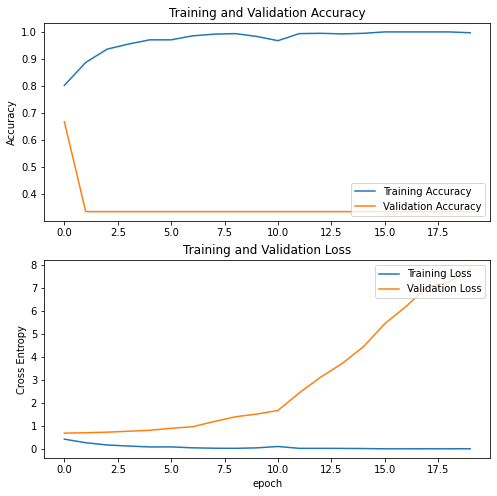

In [29]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

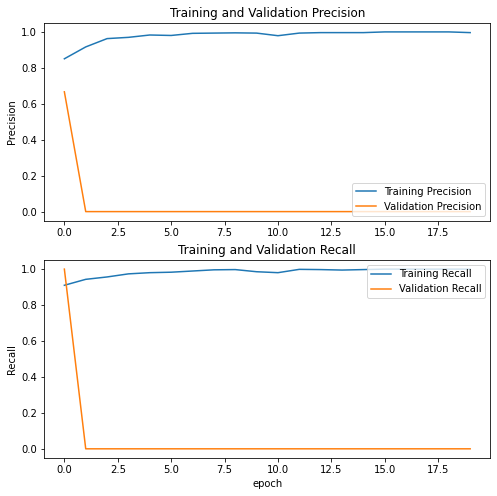

In [30]:
precision = history.history['precision']
val_precision = history.history['val_precision']

recall = history.history['recall']
val_recall = history.history['val_recall']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(precision, label='Training Precision')
plt.plot(val_precision, label='Validation Precision')
plt.legend(loc='lower right')
plt.ylabel('Precision')
plt.title('Training and Validation Precision')

plt.subplot(2, 1, 2)
plt.plot(recall, label='Training Recall')
plt.plot(val_recall, label='Validation Recall')
plt.legend(loc='upper right')
plt.ylabel('Recall')
plt.title('Training and Validation Recall')
plt.xlabel('epoch')
plt.show()